In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prysm import (
    coordinates,
    geometry,
    segmented,
    polynomials,
    propagation,
    wavelengths
)
from prysm.conf import config

# a convenient short-hand
WF = propagation.Wavefront

In [2]:
x, y = coordinates.make_xy_grid(2048, diameter=6.628)
dx = x[0,1] - x[0,0]

cha = segmented.CompositeHexagonalAperture(x,y,2,1.32,0.007,exclude=(0,))
m1 = geometry.spider(1, .1, x, y, rotation=-120)
m2 = geometry.spider(1, .1, x, y, rotation=-60)
m3 = geometry.spider(1, .1, x, y, rotation=90)
spider = m1&m2&m3

pupil_mask = cha.amp & spider


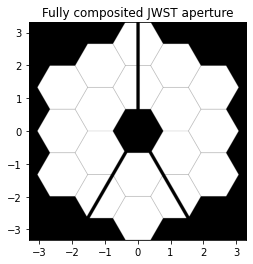

In [3]:
plt.imshow(pupil_mask, origin='lower', cmap='gray', extent=[x.min(), x.max(), y.min(), y.max()])
plt.title('Fully composited JWST aperture');

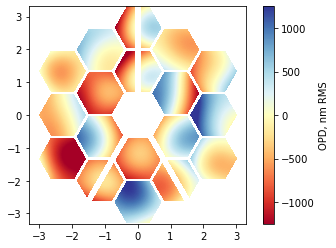

In [4]:
nms = [polynomials.noll_to_nm(j) for j in range(12)]
cha.prepare_opd_bases(polynomials.zernike_nm_sequence, nms, normalization_radius=1.32);
basis_coefs = np.zeros((len(cha.segment_ids), len(nms)), dtype=config.precision)
basis_coefs[:, 0] = np.random.uniform(-500, 500, 18)
basis_coefs[:, 1] = np.random.uniform(-1000, 1000, 18)
basis_coefs[:, 2] = np.random.uniform(-1000, 1000, 18)
basis_coefs[:, 3:] = np.random.uniform(-200, 200, 18*9).reshape((18,9))
# basis_coefs[:, :3] = 0

phase_map = cha.compose_opd(basis_coefs)
phase_map_plot = phase_map.copy()
phase_map_plot[~pupil_mask] = np.nan
im = plt.imshow(phase_map_plot, origin='lower', cmap='RdYlBu', extent=[x.min(), x.max(), y.min(), y.max()], clim=(-1250,1250))
plt.colorbar(im, label='OPD, nm RMS');

def gen_segment_vars(ref_thickness,nmodes=4,pv_frac=0.02):

    nms = [polynomials.noll_to_nm(j) for j in range(nmodes+1)]
    cha.prepare_opd_bases(polynomials.zernike_nm_sequence, nms, normalization_radius=1.32);
    basis_coefs = np.zeros((len(cha.segment_ids), len(nms)), dtype=config.precision)
    basis_coefs[:, 0] = np.random.uniform(-500, 500, 18)
    basis_coefs[:, 1] = np.random.uniform(-1000, 1000, 18)
    basis_coefs[:, 2] = np.random.uniform(-1000, 1000, 18)
    basis_coefs[:, 3:] = np.random.uniform(-500, 500, 18*(nmodes-2)).reshape((18,nmodes-2))
    # basis_coefs[:, :3] = 0

    phase_map = cha.compose_opd(basis_coefs)

    phase_map /= np.max(np.abs(phase_map))
    phase_map *= ref_thickness*pv_frac
    phase_map -= phase_map.min() - ref_thickness

    return phase_map


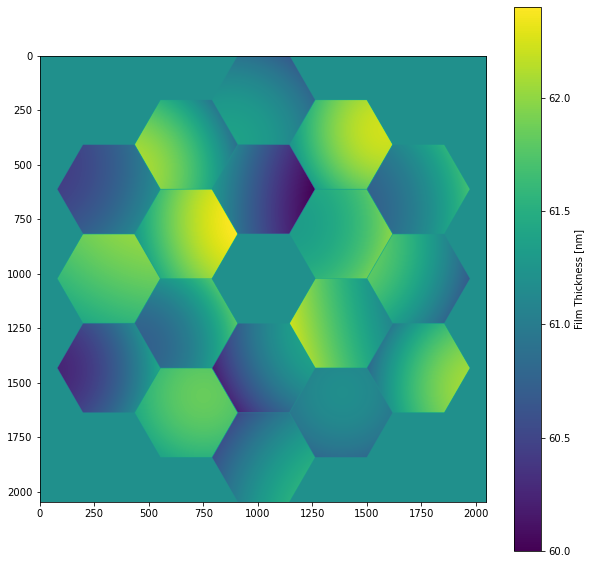

(2525327,)

In [5]:
seg_error = gen_segment_vars(60,nmodes=4) 

plt.figure(figsize=[10,10])
plt.imshow(seg_error)
plt.colorbar(label='Film Thickness [nm]')
plt.show()

seg_error[pupil_mask==1].shape

In [6]:
# Now set up the coatings
# Load the data Nasrat sent to us
def load_wl_n_k(material):
    pth = "/Users/jashcraft/Downloads/refractivedata/ag_mirror_model.xlsx"
    index_frame = pd.read_excel(pth)

    if material == 'SiO2':
        last = 201
    elif material == 'Ta2O5':
        last = 7
    elif material == 'Si3N4':
        last = 42
    elif material == 'NiCrO':
        last = 36
    elif material == 'Ag':
        last = 200
    elif material == 'BK7':
        last = 293

    wl = index_frame[f'Wavelength-{material}'][:last]
    n = index_frame[f'n-{material}'][:last]
    k = index_frame[f'k-{material}'][:last]

    # Create a spline of the data
    n_spline = interp1d(wl,n,kind='cubic')
    k_spline = interp1d(wl,k,kind='cubic')
    
    index = lambda wvl: n_spline(wvl) + 1j*k_spline(wvl)

    return index

f_SiO2 = load_wl_n_k('SiO2')
f_Ta2O5 = load_wl_n_k('Ta2O5')
f_Si3N4 = load_wl_n_k('Si3N4')
f_NiCrO = load_wl_n_k('NiCrO')
f_Ag = load_wl_n_k('Ag')
f_BK7 = load_wl_n_k('BK7')

In [7]:
# Make sure to save it
from poke.writing import write_rayfront_to_serial,read_serial_to_rayfront
# write_rayfront_to_serial(rf,'ground_prototype')
rf = read_serial_to_rayfront('/Users/jashcraft/Downloads/tfoptym_whitepaper/2048_ground_prototype.msgpack')

# plt.figure(figsize=[5,5])
# plt.scatter(rf.xData[0,0],rf.yData[0,0])
# plt.show()

In [8]:
# rf.compute_jones_pupil(aloc=np.array([0.,-1.,0.]))

In [9]:
# update the surface with segment thickness, maybe a mask_rays() function?
diameter = np.max(rf.xData[0,0]) - np.min(rf.xData[0,0]) # assumption of rotational symmetry

# compose segmented
x, y = coordinates.make_xy_grid(2048, diameter=diameter)
dx = x[0,1] - x[0,0]

rings = 6
flat_to_flat_to_vertex_vertex = 2 / np.sqrt(3)
vtov_to_flat_to_flat = 1 / flat_to_flat_to_vertex_vertex

segdiam = vtov_to_flat_to_flat * 1.44
exclude = [
    0, 1, 2, 3, 4, 5, 6, # center
    469, 470, 508, 509, 507, 510, 506, 545,
    471, 511, 505, 544, 472, 397, 433, 546, # top, bottom
    534, 533, 532, 531, 521, 522, 523, 524, # left edge
    482, 483, 484, 485, 495, 494, 493, 492, # right edge
    457, 535, 445, 520, 481, 409, 421, 496, # corners
    536, 537, 479, 480, 497, 498, 519, 518, # next 'diagonal' from corners
]
cha = segmented.CompositeHexagonalAperture(x,y,13,segdiam,0.0025,exclude=exclude)


pupil_mask = cha.amp

def gen_segment_vars(ref_thickness,nmodes=4,pv_frac=0.02):

    nms = [polynomials.noll_to_nm(j) for j in range(nmodes+1)]
    cha.prepare_opd_bases(polynomials.zernike_nm_sequence, nms, normalization_radius=1.44/2);
    basis_coefs = np.zeros((len(cha.segment_ids), len(nms)), dtype=config.precision)
    basis_coefs[:, 0] = np.random.uniform(-500, 500, 492)
    basis_coefs[:, 1] = np.random.uniform(-1000, 1000, 492)
    basis_coefs[:, 2] = np.random.uniform(-1000, 1000, 492)
    basis_coefs[:, 3:] = np.random.uniform(-1000, 1000, 492*(nmodes-2)).reshape((492,nmodes-2))
    # basis_coefs[:, :3] = 0

    phase_map = cha.compose_opd(basis_coefs)

    phase_map /= np.max(np.abs(phase_map))
    phase_map *= ref_thickness*pv_frac
    phase_map += ref_thickness

    return phase_map

<ipython-input-14-6009d8066513>:8: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(gen_segment_vars(ref_thickness=8.5,nmodes=4,pv_frac=0.1)/pupil_mask,interpolation='none',cmap='magma')


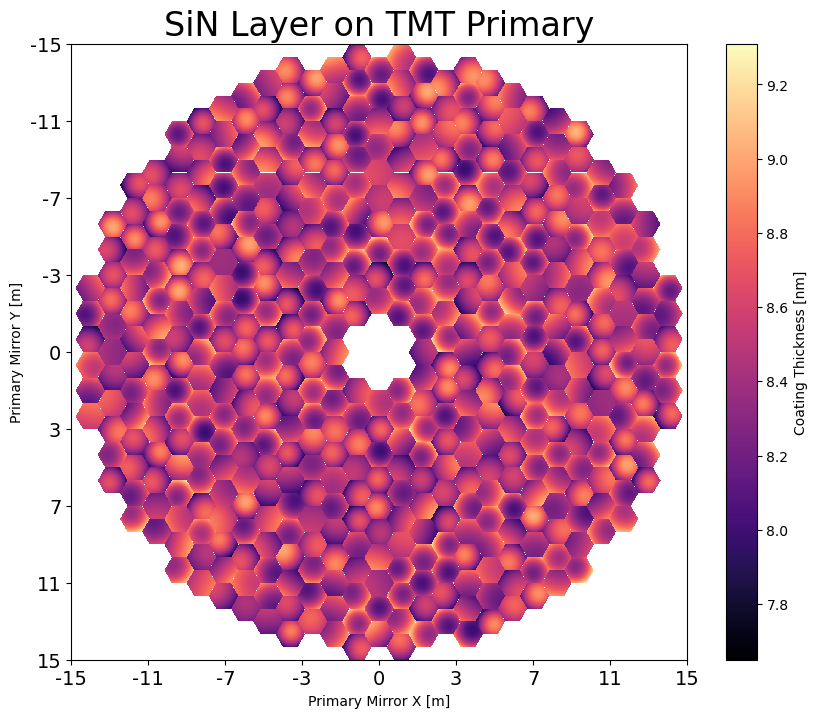

In [14]:
step = int(2048/8)
plt.style.use('default')
ticks = np.arange(0,2048+step,step)
tickstr = np.linspace(-15,15,len(ticks))
tickstr = [int(i) for i in tickstr]
plt.figure(figsize=[10,8])
plt.title('SiN Layer on TMT Primary',fontsize=24)
plt.imshow(gen_segment_vars(ref_thickness=8.5,nmodes=4,pv_frac=0.1)/pupil_mask,interpolation='none',cmap='magma')
plt.colorbar(label='Coating Thickness [nm]')
plt.xticks(ticks,tickstr,fontsize=14)
plt.yticks(ticks,tickstr,fontsize=14)
plt.xlabel('Primary Mirror X [m]')
plt.ylabel('Primary Mirror Y [m]')
plt.show()

In [12]:
def update_surflist(ncoat=1,nsurf=3,nmodes=4,wavelength=551):

    rf.wavelength = wavelength
    surflist = []

    for i in range(nsurf):

        # apply coating variation
        if i == 0:
            segment_nonuniform = gen_segment_vars(ref_thickness=8.5,pv_frac=0.05).ravel()
            protected_Ag = [
                (np.full_like(segment_nonuniform + 0*1j,f_Si3N4(wavelength)),segment_nonuniform),
                (np.full_like(segment_nonuniform + 0*1j,f_Ag(wavelength)))
            ]
        
        # apply base coating
        else:

            protected_Ag = [
                (np.full_like(segment_nonuniform + 0*1j,f_Si3N4(wavelength)),np.full_like(segment_nonuniform,8.5)),
                (np.full_like(segment_nonuniform + 0*1j,f_Ag(wavelength)))
            ]

        
        sN = {
            'coating':protected_Ag,
            'mode':'reflect'
        }

        surflist.append(sN)
    
    rf.surfaces = surflist
    if nsurf < 3:
        rf.compute_jones_pupil(aloc=np.array([0.,0.,1.]))
    else:
        rf.compute_jones_pupil(aloc=np.array([0.,-1.,0.]))


update_surflist(nsurf=3)


In [12]:
# import poke.plotting as plot
# plot.jones_pupil(rf)

In [13]:
from poke.poke_math import eigenvalues_2x2

def retardance(jones):
    e1,e2 = eigenvalues_2x2(jones)
    return np.angle(e1) - np.angle(e2)

jreg = rf.jones_pupil[-1].reshape([2048,2048,3,3])[...,:2,:2]



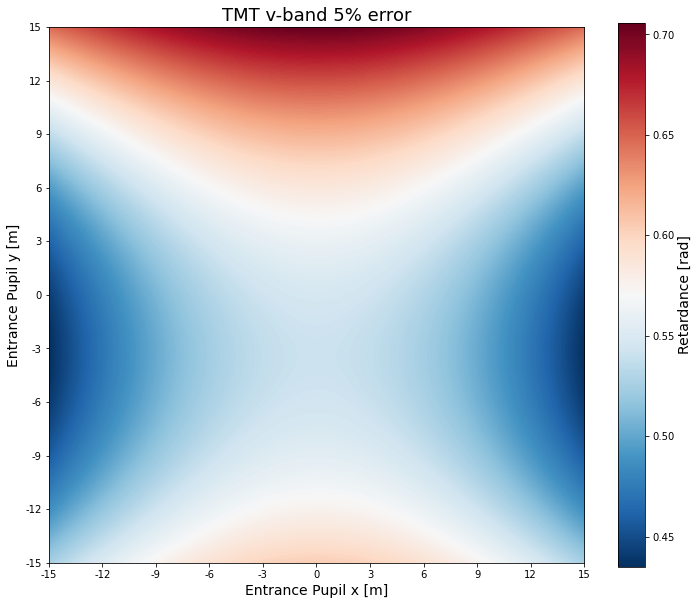

In [14]:
plt.figure(figsize=[12,10])
plt.title('TMT v-band 5% error')
plt.imshow(retardance(jreg),cmap='RdBu_r')
plt.xticks(np.linspace(0,2048,int(30/3)+1),np.arange(-15,18,3))
plt.yticks(np.linspace(0,2048,int(30/3)+1),np.arange(-15,18,3))
plt.xlabel('Entrance Pupil x [m]')
plt.ylabel('Entrance Pupil y [m]')
plt.colorbar(label='Retardance [rad]')
plt.show()

In [13]:
def broadcast_kron(A,B):
    """Kronecker product for two dimensional arrays with numpy's broadcasting rules

    Parameters
    ----------
    A : numpy.ndarray
        first array for kronecker product
    B : numpy.ndarray
        second array for kronecker product

    Returns
    -------
    numpy.ndarray
        A kron B
    """
    return np.einsum('...ik,...jl',A,B)

def broadcast_outer(A,B):

    return np.einsum('...j,...k',A,B)

def jones_to_mueller(jones):

    """Converts a Jones matrix to a Mueller matrix

    Parameters
    ----------
    jones : 2x2 ndarray
        Jones matrix to convert to a mueller matrix

    Returns
    -------
    M
        Mueller matrix from Jones matrix
    """

    U = np.array([[1,0,0,1],
                  [1,0,0,-1],
                  [0,1,1,0],
                  [0,1j,-1j,0]])

    U *= np.sqrt(1/2)

    M = np.real(U @ (np.kron(np.conj(jones),jones)) @ np.linalg.inv(U))

    return M

def jones_to_mueller_broadcast(jones):

    U = np.array([[1,0,0,1],
                  [1,0,0,-1],
                  [0,1,1,0],
                  [0,1j,-1j,0]])

    U *= np.sqrt(1/2)
    U = np.broadcast_to(U,(*jones.shape[:-2],4,4))
    print(U.shape)
    inner = broadcast_kron(jones.conj(),jones).reshape([*jones.shape[:-2],4,4])
    M = np.real(U @ inner @ np.linalg.inv(U))
    return M

In [16]:
mul = jones_to_mueller_broadcast(rf.jones_pupil[-1][...,:2,:2])

(4194304, 4, 4)


In [17]:
broadcast_kron(jreg,jreg).shape

(2048, 2048, 2, 2, 2, 2)

In [18]:
mul_shaped = mul.reshape([2048,2048,4,4])

In [81]:
def plot_polarizance(mul,tol=2e-2,norm='linear',mask=None):

    fig,axs = plt.subplots(ncols=4,figsize=[20,4])
    _data = mul[...,:,0]
    _data = np.swapaxes(_data,-1,0)
    if mask is not None:
        data = [i/mask for i in _data]
    else:
        data = _data
    titles = ['I','Q','U','V']
    i = 0
    for ax,dat,title in zip(axs,data,titles):

        if norm == 'log':
            im = ax.imshow(np.log10(np.abs(dat)),cmap='YlGnBu_r')
        else:
            im = ax.imshow((dat),cmap='RdBu_r')
        div = make_axes_locatable(ax)
        cax = div.append_axes("right",size="5%",pad=0.05)
        ax.set_xticks([0])
        ax.set_yticks([0])
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        ax.set_title(title)
        fig.colorbar(im,cax=cax)
        i += 1

def plot_fractional_polarization(mul,tol=2e-2,norm='linear',vmin=-1,vmax=1):

    fig,axs = plt.subplots(ncols=4,figsize=[20,4])
    data = mul[...,:,0]
    data = np.swapaxes(data,-1,0)
    m00 = data[0]
    titles = ['I','Q','U','V']
    i = 0
    for ax,dat,title in zip(axs,data,titles):

        if norm == 'log':
            im = ax.imshow(np.log10(np.abs(dat)/m00),cmap='RdBu_r')
        else:
            im = ax.imshow((dat)/m00,vmin=vmin,vmax=vmax,cmap='RdBu_r')
        div = make_axes_locatable(ax)
        cax = div.append_axes("right",size="5%",pad=0.05)
        ax.set_xticks([0])
        ax.set_yticks([0])
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        ax.set_title(title)
        fig.colorbar(im,cax=cax)
        i += 1
    

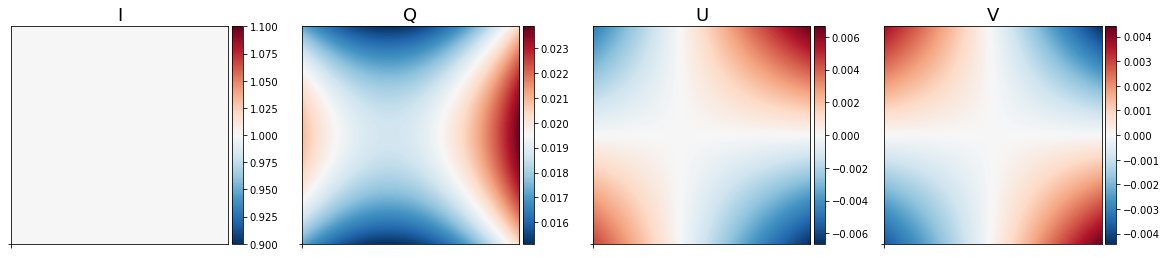

In [91]:
tol = 7e-2
plot_fractional_polarization(mul_shaped,vmin=None,vmax=None)

# Do the HCIPy Propagation

In [16]:
from hcipy import *
from poke.interfaces import jones_pupil_to_hcipy_wavefront
x = np.linspace(-1,1,2048)
x,y = np.meshgrid(x,x)
r = np.sqrt(x**2 + y**2)
mask = np.zeros_like(r)
mask[r<1] = 1

<ipython-input-62-508850007974>:7: RuntimeWarning: invalid value encountered in divide
  imshow_field(wvfnt.Q/pupil_mask.ravel())


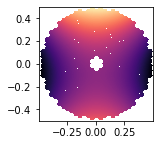

In [62]:
pupil_grid = make_pupil_grid(2048)
focal_grid = make_focal_grid(16,12)
wvfnt = jones_pupil_to_hcipy_wavefront(rf.jones_pupil,pupil_grid)
prop = FraunhoferPropagator(pupil_grid,focal_grid)
aperture = make_circular_aperture(1)
wvfnt.electric_field *= pupil_mask.ravel()
imshow_field(wvfnt.Q/pupil_mask.ravel())

In [133]:
to_psf = prop(wvfnt)
to_psf_shaped = to_psf.electric_field.shaped
to_psf_shaped = np.moveaxis(to_psf_shaped,0,-1)
to_psf_shaped = np.moveaxis(to_psf_shaped,0,-1)

(384, 384, 4, 4)


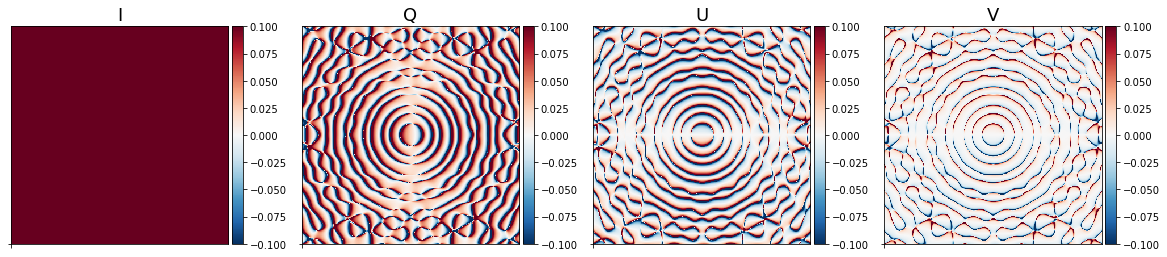

In [145]:
to_psf_mul = jones_to_mueller_broadcast(to_psf_shaped)
plot_fractional_polarization(to_psf_mul,norm='linear',vmin=-tol,vmax=tol)

In [138]:
m00 = to_psf_mul[...,0,0] # I
m10 = to_psf_mul[...,1,0] # Q
m20 = to_psf_mul[...,2,0] # U
m30 = to_psf_mul[...,3,0] # V

In [139]:
def fractional_polarization(I,S):
    """
    Parameters
    ---------
    I : numpy.ndarray
        Stokes I
    S : numpy.ndarray
        Stokes Parameter
    """
    return (I-S)/I

DoLP = np.sqrt(m10**2 + m20**2)/m00
DoP = np.sqrt(m10**2 + m20**2 + m30**2)/m00

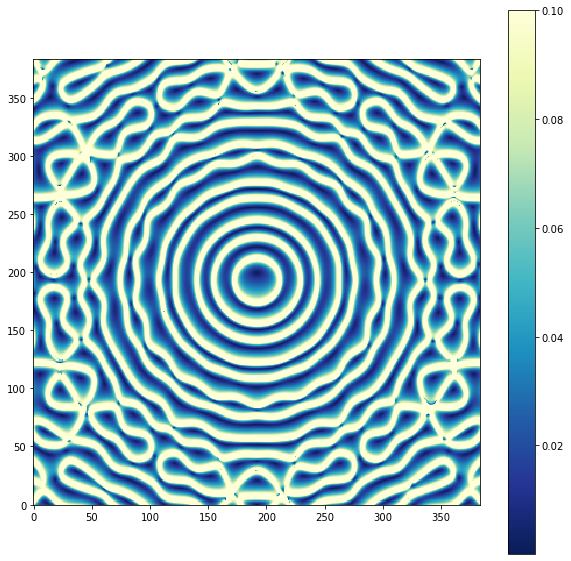

In [140]:
tol = 1e-1

plt.figure(figsize=[10,10])
plt.imshow(DoP,cmap='YlGnBu_r',vmax=0.1)
plt.colorbar()
plt.show()

In [46]:
def plot_mueller(mul,crop=16,title=None):

    imsize = mul[...,0,0].shape[0]/2
    fig,axs = plt.subplots(ncols=4,nrows=4,figsize=[19,15])
    if title is not None:
        fig.suptitle(title,fontsize=24)
    for i in range(4):
        for j in range(4):
            ax = axs[i,j]
            im = ax.imshow(mul[...,i,j],cmap='RdBu_r')
            div = make_axes_locatable(ax)
            cax = div.append_axes("right",size="5%",pad=0.05)
            ax.set_xticks([0])
            ax.set_yticks([0])
            ax.set_xticklabels('')
            ax.set_yticklabels('')
            ax.set_xlim(imsize-crop,imsize+crop)
            ax.set_ylim(imsize-crop,imsize+crop)
            cbar = fig.colorbar(im,cax=cax)
            cbar.ax.tick_params(labelsize=14)
    plt.subplots_adjust()
    plt.show()

def plot_normalized_mueller(mul,crop=16,title=None):
    ref = mul[...,0,0]
    imsize = mul[...,0,0].shape[0]/2
    fig,axs = plt.subplots(ncols=4,nrows=4,figsize=[19,15])
    if title is not None:
        fig.suptitle(title,fontsize=24)
    for i in range(4):
        for j in range(4):
            ax = axs[i,j]
            im = ax.imshow(mul[...,i,j]/ref,cmap='RdBu_r')
            div = make_axes_locatable(ax)
            cax = div.append_axes("right",size="5%",pad=0.05)
            ax.set_xticks([0])
            ax.set_yticks([0])
            ax.set_xticklabels('')
            ax.set_yticklabels('')
            ax.set_xlim(imsize-crop,imsize+crop)
            ax.set_ylim(imsize-crop,imsize+crop)
            cbar = fig.colorbar(im,cax=cax)
            cbar.ax.tick_params(labelsize=14)
    plt.subplots_adjust()
    plt.show()

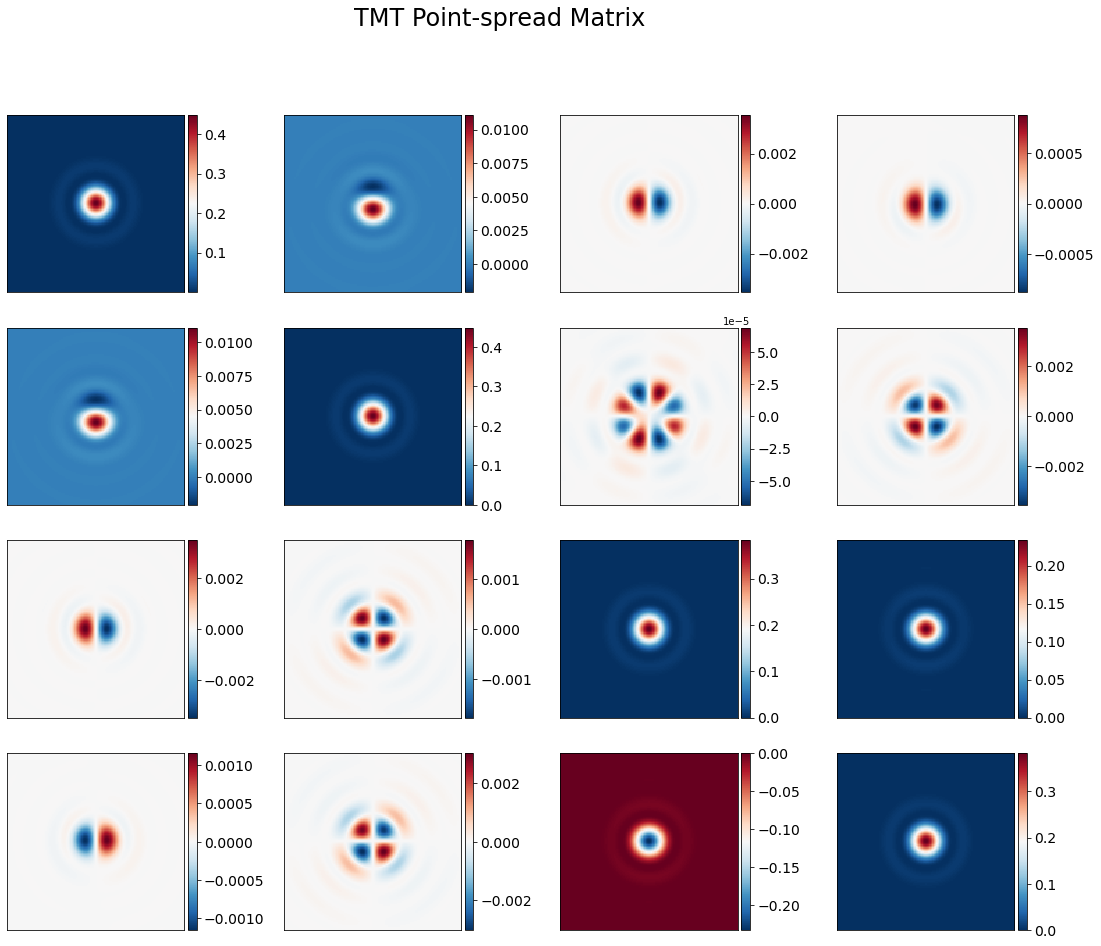

In [158]:
plot_mueller(to_psf_mul,crop=64,title='TMT Point-spread Matrix')

In [30]:
from poke.polarization import jones_to_mueller

to_psf_slow = np.empty_like(to_psf_mul)

for i in range(to_psf_shaped.shape[0]):
    for j in range(to_psf_shaped.shape[1]):
        to_psf_slow[i,j] = jones_to_mueller(to_psf_shaped[i,j])

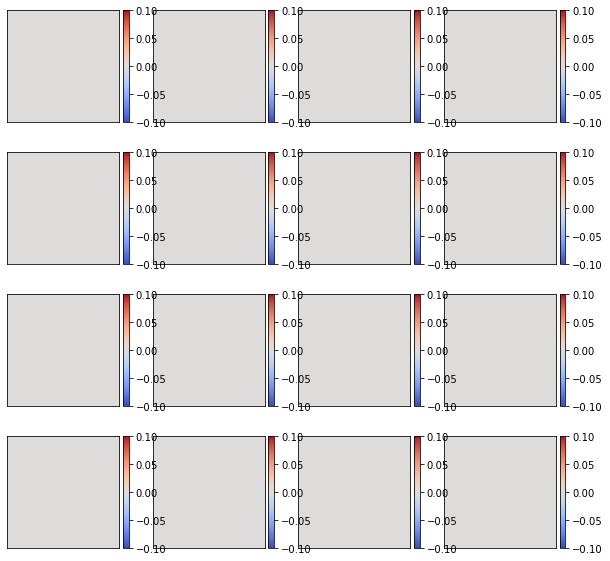

In [31]:
plot_mueller(to_psf_slow-to_psf_mul,crop=32)

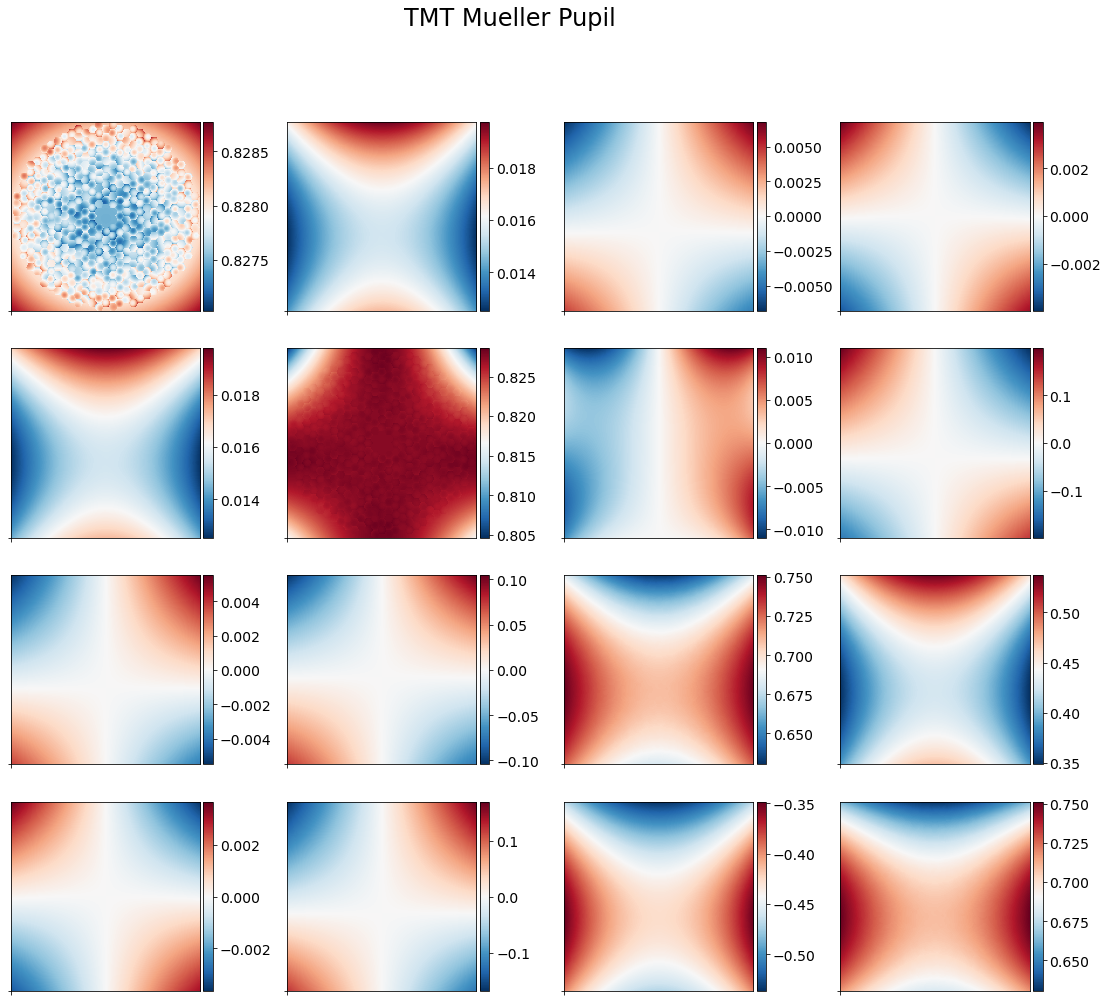

In [131]:
plot_mueller(mul_shaped,crop=1024,title='TMT Mueller Pupil')

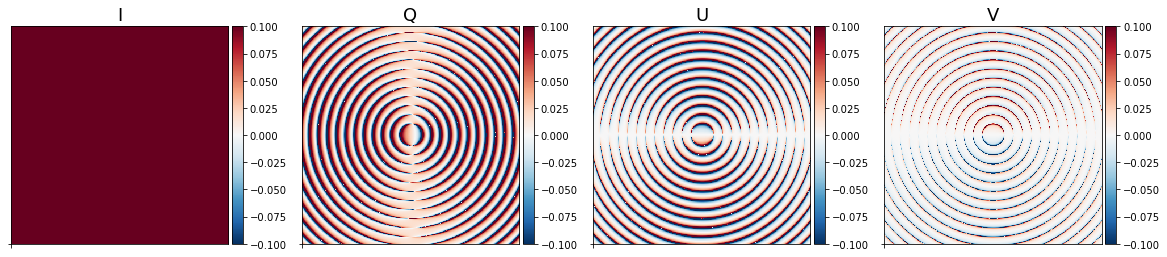

In [48]:
tot = 1e-1
plot_fractional_polarization(to_psf_mul,vmin=-tot,vmax=tot)

## Set up HCIPy propagation

In [63]:
class LinearDiattenuator(JonesMatrixOpticalElement):
	'''A linear polarizer.
	Parameters
	----------
	polarization_angle : scalar or Field
		The polarization angle of the polarizer. Light with this angle is transmitted.
	'''
	def __init__(self, polarization_angle, diattenuation):
		self.polarization_angle = polarization_angle
		self.diattenuation = diattenuation
		JonesMatrixOpticalElement.__init__(self, self.jones_matrix)

	@property
	def jones_matrix(self):
		def jones(angle):
			rotmat = lambda theta: np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
			jones_inner = np.array([[1,0],[0,1-self.diattenuation]])


			return rotmat(-angle) @ jones_inner @ rotmat(angle)

		return self.construct_function(jones, self.polarization_angle)

	@jones_matrix.setter
	def jones_matrix(self, b):
		pass

	@property
	def polarization_angle(self):
		'''The angle of polarization of the linear polarizer.
		'''
		return self._polarization_angle

	@polarization_angle.setter
	def polarization_angle(self, angle):
		self._polarization_angle = angle

		self.clear_cache()


dia = 1-1/np.sqrt(100000)

def vvc_prop(wf,charge,use_polarizer=False,tilt=0):
    """propagates through HCIPy VectorVortexCoronagraph

    Parameters
    ----------
    jdata : list of length 4
        list containing the 4 jones pupil elements: Jxx, Jxy, Jyx, Jyy
    charge : int
        topological charge of the vortex
    """
    aperture = evaluate_supersampled(make_circular_aperture(1),pupil_grid,1)
    lyot = evaluate_supersampled(make_circular_aperture(0.8),pupil_grid,4)

    # setup and propagate vvc
    lyot_stop = Apodizer(lyot)
    aperture_stop = Apodizer(aperture)
    coro = VectorVortexCoronagraph(charge,lyot_stop=lyot)
    coro.make_instance(coro.get_instance_data(pupil_grid,focal_grid,1),pupil_grid,focal_grid,1)

    if use_polarizer:
        # create circular polarizer
        hpol = LinearDiattenuator(0,dia)
        qwp = QuarterWavePlate(np.pi/4)
        wf = hpol.forward(wf)
        wf = qwp.forward(wf)

    wf_coro = coro.forward(wf)
    wf_lyot = lyot_stop(wf_coro)

    if use_polarizer:
        vpol = LinearDiattenuator(np.pi/2,dia)
        qwp = QuarterWavePlate(-np.pi/4)
        wf_lyot = qwp.forward(wf_lyot)
        wf_lyot = vpol.forward(wf_lyot)

    img = prop(wf_lyot)

    shape = int(np.sqrt(img.intensity.shape[0]))

    cmplx_field = img.electric_field.reshape([shape,shape,2,2])

    return img,wf_lyot

In [64]:
phase_xx = np.angle(wvfnt.electric_field[0,0])
phase_yy = np.angle(wvfnt.electric_field[1,1])
dm_correction = phase_xx # + phase_yy)
wvfnt.electric_field *= np.exp(-1j*dm_correction)

In [65]:
charge = 2

# set up scalar reference wvfnt
wvfnt_scalar = Wavefront(Field(pupil_mask.ravel(),pupil_grid),input_stokes_vector=[1,0,0,0])

vvc_field_polarized,vvc_lyot_polarized = vvc_prop(wvfnt,charge,use_polarizer=True)
vvc_field_scalar,vvc_lyot_scalar = vvc_prop(wvfnt_scalar,charge,use_polarizer=True)

In [66]:
def hcipy_field_to_array(field):
    jout = field.electric_field.shaped
    jout = np.moveaxis(jout,-1,0)
    jout = np.moveaxis(jout,-1,0)
    return jout

coro_jones_pol = hcipy_field_to_array(vvc_field_polarized)
lyot_jones_pol = hcipy_field_to_array(vvc_lyot_polarized)
coro_jones_unpol = hcipy_field_to_array(vvc_field_scalar)
lyot_jones_unpol = hcipy_field_to_array(vvc_lyot_scalar)

In [67]:
pol_mpsm = jones_to_mueller_broadcast(coro_jones_pol)
pol_muel = jones_to_mueller_broadcast(lyot_jones_pol)
unpol_mpsm = jones_to_mueller_broadcast(coro_jones_unpol)
unpol_muel = jones_to_mueller_broadcast(lyot_jones_unpol)

(384, 384, 4, 4)
(2048, 2048, 4, 4)
(384, 384, 4, 4)
(2048, 2048, 4, 4)


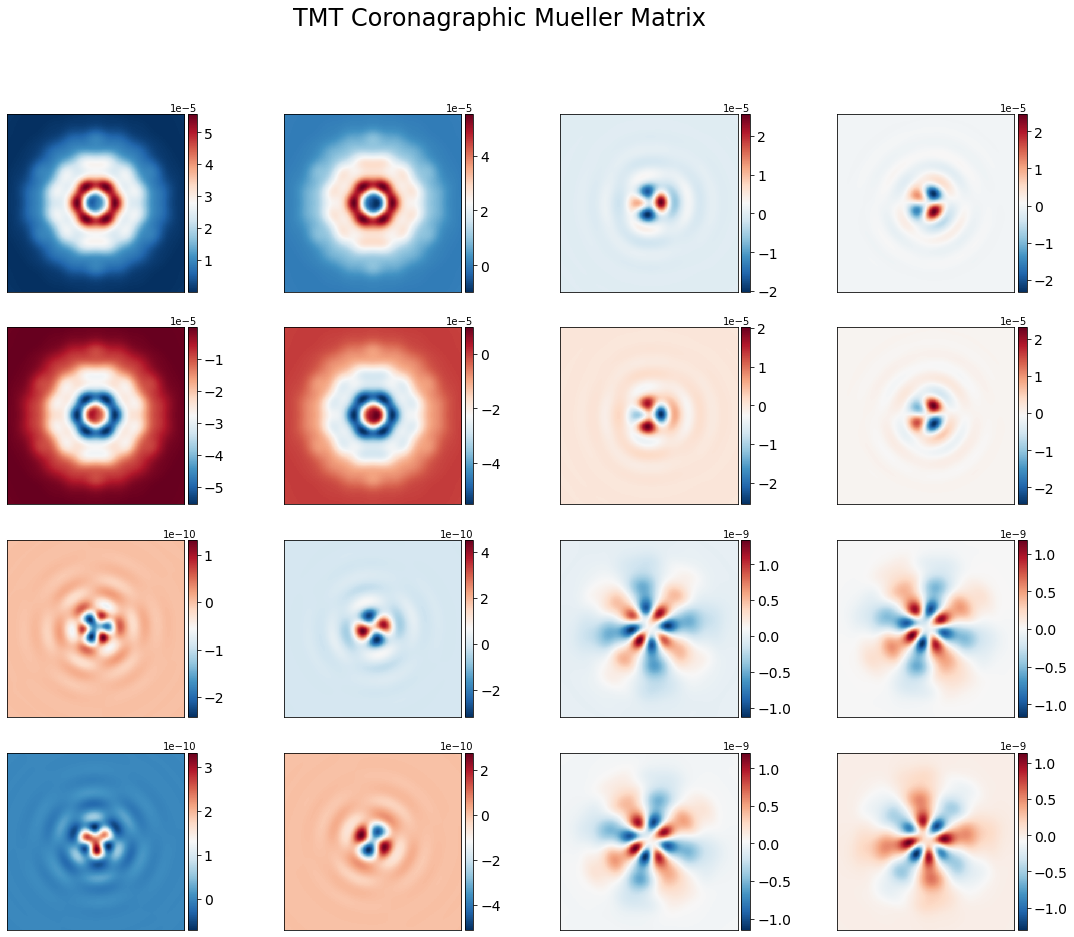

In [68]:
plot_mueller(pol_mpsm,crop=150,title='TMT Coronagraphic Mueller Matrix')

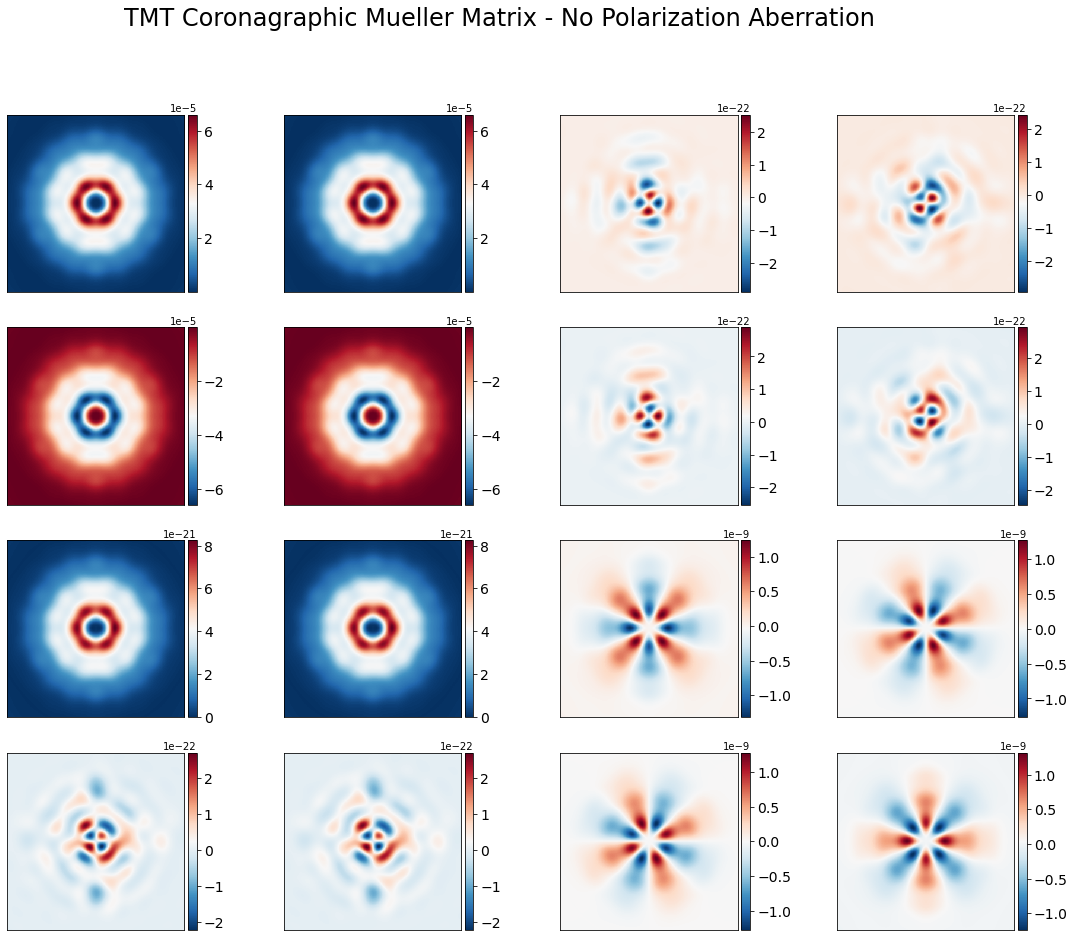

In [69]:
plot_mueller(unpol_mpsm,crop=150,title='TMT Coronagraphic Mueller Matrix - No Polarization Aberration')

<ipython-input-46-0fd3cc14ba1e>:33: RuntimeWarning: invalid value encountered in divide
  im = ax.imshow(mul[...,i,j]/ref,cmap='RdBu_r')


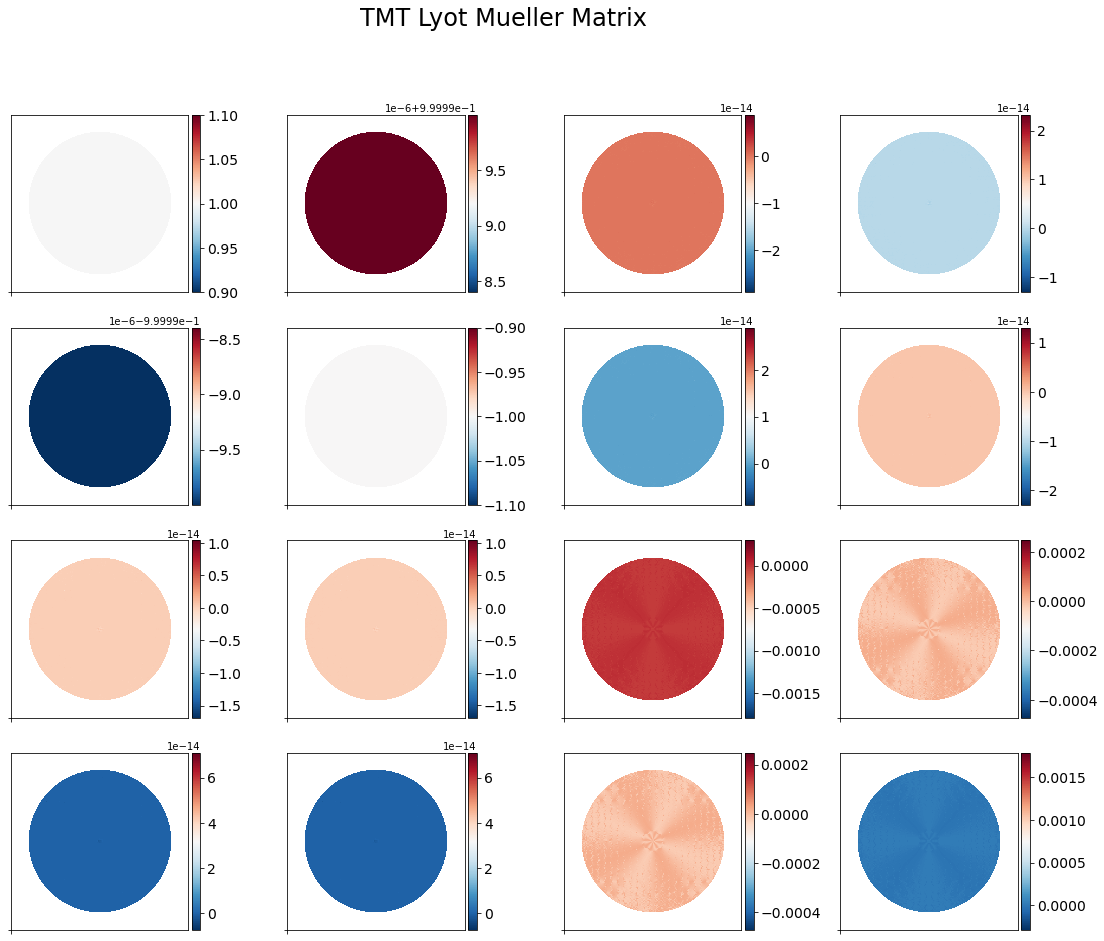

In [70]:
plot_normalized_mueller(unpol_muel,crop=1024,title='TMT Lyot Mueller Matrix')

In [38]:
def compute_m00(field):
    return 0.5*(np.abs(field[...,0,0])**2 + np.abs(field[...,0,1])**2 + np.abs(field[...,1,0])**2 + np.abs(field[...,1,1])**2)

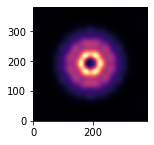

In [39]:
plt.imshow(compute_m00(jout))